In [1]:
# Text Classification / tc-nltk-lstm-rnn-1.ipynb
# Gourav Siddhad
# 16-Mar-2019

In [17]:
print('Importing Libraries', end='')

import pandas as pd
import numpy as np
from numpy.random import seed
import re
import os
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns
import pydot

import nltk
from nltk import word_tokenize
from nltk.corpus import reuters, stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, minmax_scale
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical, plot_model
from keras.callbacks import EarlyStopping

%matplotlib inline

from scipy import interp
from itertools import cycle

print(' - Done')

Importing Libraries - Done


In [3]:
documents = reuters.fileids()
print('Total Documents -', len(documents))

print('Extracting (Id, Docs and Labels)', end='')
train_docs_id = list(filter(lambda doc: doc.startswith("train"), documents))
test_docs_id = list(filter(lambda doc: doc.startswith("test"), documents))

train_docs = [reuters.raw(doc_id) for doc_id in train_docs_id]
test_docs = [reuters.raw(doc_id) for doc_id in test_docs_id]
all_docs = train_docs
all_docs += test_docs

train_labels = [reuters.categories(doc_id) for doc_id in train_docs_id]
test_labels  = [reuters.categories(doc_id) for doc_id in test_docs_id]
all_labels = train_labels
all_labels += test_labels
print(' - Done')

del train_docs
del test_docs
del train_labels
del test_labels

print('Documents - ', len(all_docs))
print('Labels  - ', len(all_labels))

# List of categories
categories = reuters.categories()
print('Categories - ', len(categories))

Total Documents - 10788
Extracting (Id, Docs and Labels) - Done
Documents -  10788
Labels  -  10788
Categories -  90


In [4]:
print('Caching Stop Words', end='')
cachedStopWords = stopwords.words("english")
print(' - Done')

Caching Stop Words - Done


In [5]:
print('Sorting Train:Test Docs', end='')
X_train, X_test, y_train, y_test = train_test_split(all_docs, all_labels, test_size=0.2, random_state=42)
print(' - Done')

maxwords = 2000

print('Tokenizing', end='')
tk = Tokenizer(num_words=maxwords)
tk.fit_on_texts(X_train)
tk.fit_on_texts(X_test)
index_list_train = tk.texts_to_sequences(X_train)
index_list_test = tk.texts_to_sequences(X_test)
print(' - Done')

Sorting Train:Test Docs - Done
Tokenizing - Done


In [6]:
# max of index_list_train
# max of index_list_test

maxlen = 150

for i in index_list_train:
    if len(i)>maxlen:
        maxlen = len(i)
print(maxlen)

for i in index_list_test:
    if len(i)>maxlen:
        maxlen = len(i)
print(maxlen)

1920
1920


In [7]:
maxlen = 1200

print('Padding Sequences', end='')
x_train = sequence.pad_sequences(index_list_train, maxlen=maxlen)
x_test = sequence.pad_sequences(index_list_test, maxlen=maxlen)
print(' - Done')

print('Binarizing MultiLabels', end='')
lb = MultiLabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
print(' - Done')

del all_docs
del all_labels

Padding Sequences - Done
Binarizing MultiLabels - Done


In [8]:
def RNN():
    inputs = Input(name='inputs', shape=[maxlen])
    layer = Embedding(maxwords, 512, input_length=maxlen)(inputs)
    layer = LSTM(256)(layer)
    layer = Dense(128, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(rate = 0.4)(layer)
    layer = Dense(len(categories), name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [9]:
model = RNN()
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 1200)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1200, 512)         1024000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               787456    
_________________________________________________________________
FC1 (Dense)                  (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
out_layer (Dense)            (None, 90)                11610     
__________

In [10]:
history = model.fit(x_train, y_train, batch_size=256, epochs=25, validation_split=0.20, shuffle=True)#, 
#                     callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])

Train on 6904 samples, validate on 1726 samples
Epoch 1/25
6904/6904 [==============================] - 102s 15ms/step - loss: 3.9735 - acc: 0.3705 - val_loss: 3.4911 - val_acc: 0.4229
Epoch 2/25
6904/6904 [==============================] - 92s 13ms/step - loss: 3.1334 - acc: 0.5007 - val_loss: 2.8432 - val_acc: 0.5394
Epoch 3/25
6904/6904 [==============================] - 91s 13ms/step - loss: 2.7328 - acc: 0.5576 - val_loss: 2.5400 - val_acc: 0.5939
Epoch 4/25
6904/6904 [==============================] - 92s 13ms/step - loss: 2.4851 - acc: 0.6160 - val_loss: 2.5334 - val_acc: 0.5736
Epoch 5/25
6904/6904 [==============================] - 93s 13ms/step - loss: 2.3615 - acc: 0.6140 - val_loss: 2.3390 - val_acc: 0.6315
Epoch 6/25
6904/6904 [==============================] - 93s 13ms/step - loss: 2.1858 - acc: 0.6375 - val_loss: 2.1344 - val_acc: 0.6593
Epoch 7/25
6904/6904 [==============================] - 94s 14ms/step - loss: 2.0172 - acc: 0.6709 - val_loss: 2.0725 - val_acc: 0.6767

In [11]:
# Save Complete Model
model.save('tc-nltk-lstm-rnn-1.h5')

# Load a Saved Model
# model = load_model('tc-nltk-lstm-rnn.h5')

# Delete a model
# del model

# Save Model Configuration to JSON
model_json = model.to_json()
with open('tc-nltk-lstm-rnn-1.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('tc-nltk-lstm-rnn-1-weights.h5')

# Load Model Configuration from JSON
# json_file = open('tc-nltk-lstm-rnn.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# loaded_model.load_weights('tc-nltk-lstm-rnn-weights.h5')
# loaded_model.save('tc-nltk-lstm-rnn-weights.hdf5')
# loaded_model=load_model('tc-nltk-lstm-rnn-weights.hdf5')

In [12]:
accr = model.evaluate(x_test, y_test)
print()
print('Loss: {:0.3f}\tAccuracy: {:0.3f}'.format(accr[0], accr[1]))

2158/2158 [==============================] - 55s 26ms/step

Loss: 1.993	Accuracy: 0.751


In [19]:
# plot_model(model, to_file='tc-nltk-lstm-1-model.png')

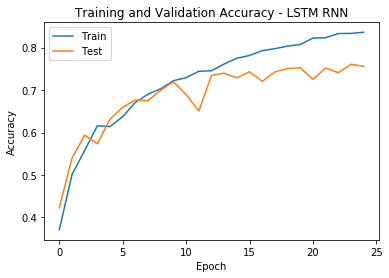

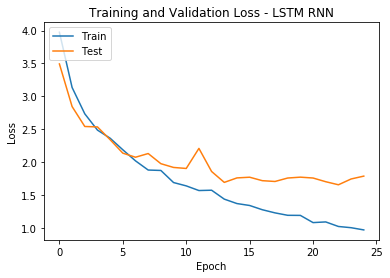

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training and Validation Accuracy - LSTM RNN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('tc-nltk-lstm-rnn-1-acc.png', dpi=300, pad_inches=0.1)
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss - LSTM RNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('tc-nltk-lstm-rnn-1-loss.png', dpi=300, pad_inches=0.1)
plt.show()